In [1]:
import time
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, './CFE')
import bmi_cfe_open
import bmi_cfe_enkf_peturb
#import bmi_cfe_peturb

sys.path.insert(0, './Assimilation')
import Bmi_da_ENKF_forSBMI

#sys.path.append('/home/jovyan/data/NextGen---The-Simulators-/USGS/USGS_BMI_FT/cleaned_FT')
sys.path.append('../USGS/USGS_BMI_FT')
import bmi_usgs

#new bmi_cfe is CFE open and cfe peturb

In [2]:
print(bmi_cfe_open)
#print(bmi_cfe_peturb)
print(bmi_cfe_enkf_peturb)
print(Bmi_da_ENKF_forSBMI)
print(bmi_usgs)


<module 'bmi_cfe_open' from 'C:\\Users\\zjbut\\Documents\\GitHub\\NextGen---The-Simulators-\\Toy_Model\\./CFE\\bmi_cfe_open.py'>
<module 'bmi_cfe_enkf_peturb' from 'C:\\Users\\zjbut\\Documents\\GitHub\\NextGen---The-Simulators-\\Toy_Model\\./CFE\\bmi_cfe_enkf_peturb.py'>
<module 'Bmi_da_ENKF_forSBMI' from 'C:\\Users\\zjbut\\Documents\\GitHub\\NextGen---The-Simulators-\\Toy_Model\\./Assimilation\\Bmi_da_ENKF_forSBMI.py'>
<module 'bmi_usgs' from 'C:\\Users\\zjbut\\Documents\\GitHub\\NextGen---The-Simulators-\\Toy_Model\\../USGS/USGS_BMI_FT\\bmi_usgs.py'>


In [3]:
## Open BMI's for each file
# cfe_open = bmi_cfe.BMI_CFE()
# cfe_peturbed = bmi_cfe_peturb.BMI_CFE()
# cfe_analysis = bmi_cfe_statevars.BMI_CFE() #true model in the end with updated state vars

cfe_open = bmi_cfe_open.BMI_CFE()
cfe_peturbed = bmi_cfe_enkf_peturb.BMI_CFE()
cfe_analysis = bmi_cfe_enkf_peturb.BMI_CFE() #true model in the end with updated state vars
#cfe_analysis = bmi_cfe_statevars_et.BMI_CFE(

enkf = Bmi_da_ENKF_forSBMI.EnKF_wrap()
usgs = bmi_usgs.BMI_USGS()

In [4]:
## Initialize the BMI's
#cfe_open.initialize(cfg_file='./CFE/cat_58_config_cfe.json')
#cfe_peturbed.initialize(cfg_file='./CFE/cat_58_config_cfe_peturb_model.json')
#cfe_analysis.initialize(cfg_file='./CFE/cat_58_config_cfe.json') # I am confused what this config file should look like

# make one bmi for all of this and options in config file

# ## Case study files
cfe_open.initialize(cfg_file='./CFE/config_cfe_peturb_model_CT.json')
cfe_peturbed.initialize(cfg_file='./CFE/config_cfe_peturb_model_CT.json')
cfe_analysis.initialize(cfg_file='./CFE/config_cfe_peturb_model_CT.json')

enkf.initialize(cfg_file='./Assimilation/EnKF_config.json') # Need to create this still
usgs.initialize(cfg_file='../USGS/USGS_BMI_FT/usgs_config.json')



initialized 84
                         Date     Flow  validity
0   2017-05-15 04:00:00+00:00  166.500       1.0
1   2017-05-15 05:00:00+00:00  161.000       1.0
2   2017-05-15 06:00:00+00:00  156.750       1.0
3   2017-05-15 07:00:00+00:00  151.500       1.0
4   2017-05-15 08:00:00+00:00  148.750       1.0
..                        ...      ...       ...
763 2017-06-15 23:00:00+00:00   28.400       1.0
764 2017-06-16 00:00:00+00:00   28.175       1.0
765 2017-06-16 01:00:00+00:00   28.400       1.0
766 2017-06-16 02:00:00+00:00   27.500       1.0
767 2017-06-16 03:00:00+00:00   27.500       1.0

[768 rows x 3 columns]
USGS station ID 01123000


                time  APCP_surface  RAINRATE      T2D       Q2D     U2D  \
0     5/15/2017 0:00           0.0       0.0  284.078  0.006616  6.0804   
1     5/15/2017 1:00           0.0       0.0  283.180  0.006650  6.0304   
2     5/15/2017 2:00           0.0       0.0  282.440  0.006614  5.9856   
3     5/15/2017 3:00           0.0       0.0  281.662  0.006476  5.9402   
4     5/15/2017 4:00           0.0       0.0  281.702  0.006530  6.3688   
..               ...           ...       ...      ...       ...     ...   
763  6/15/2017 19:00           0.0       0.0  295.270  0.007334 -1.1600   
764  6/15/2017 20:00           0.0       0.0  294.610  0.006788 -1.2230   
765  6/15/2017 21:00           0.0       0.0  293.624  0.006776 -1.2812   
766  6/15/2017 22:00           0.0       0.0  292.722  0.006714 -1.5682   
767  6/15/2017 23:00           0.0       0.0  291.554  0.006650 -1.8486   

        V2D       PSFC   SWDOWN   LWDOWN  
0   -1.9670   98376.98    0.000  318.822  
1   -2.0740  

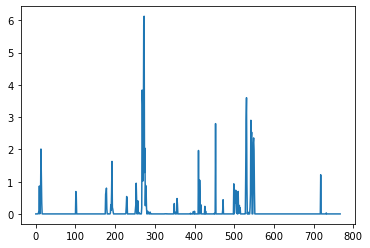

In [5]:
with open(cfe_open.forcing_file, 'r') as f:
    df_forcing = pd.read_csv(f)
    
print(df_forcing)
plt.plot(df_forcing['APCP_surface'])

values = df_forcing['APCP_surface']
print(values)

In [6]:
#Originial Version 
#Make empty matrices for plotting
cfeOpen = []
cfePeturbed = []
cfeAnalysis = []
cfeEnKF = []

## Loop through time. Set values for each model and get values
for i, precip in enumerate(df_forcing['APCP_surface']): #i is RAINRATE

    # Set values for each model
    cfe_open.set_value('atmosphere_water__time_integral_of_precipitation_mass_flux', precip) #value of precip from forcing data in loop
    cfe_peturbed.set_value('atmosphere_water__time_integral_of_precipitation_mass_flux', precip)
    cfe_analysis.set_value('atmosphere_water__time_integral_of_precipitation_mass_flux', precip)
    
    # Update usgs data and get value to put into EnKF
    usgs.update()
    obs = np.array(usgs.get_value('Flow')) #need array for EnKf function. should get this when initialize.  
    
    
    # print("1 soil moisture: open", cfe_open._values["soil_storage_avail_m"])
    # print("1 soil moisture: peturbed", cfe_peturbed._values["soil_storage_avail_m"])
    # print("1 soil moisture: analysis", cfe_analysis._values["soil_storage_avail_m"])
    # print("1 runoff: open", cfe_open._values["DIRECT_RUNOFF"])
    # print("1 runoff: peturbed", cfe_peturbed._values["DIRECT_RUNOFF"])
    # print("1 runoff: analysis", cfe_analysis._values["DIRECT_RUNOFF"])
    # print("\n")
    
    # Update CFE open and peturbed. Get value for peturbed stats. 
    cfe_open.update()
    cfe_peturbed.update()
    
#     print("2 soil moisture: open", cfe_open._values["soil_storage_avail_m"])
#     print("2 soil moisture: peturbed", cfe_peturbed._values["soil_storage_avail_m"])
#     print("2 soil moisture: analysis", cfe_analysis._values["soil_storage_avail_m"])
#     print("2 runoff: open", cfe_open._values["DIRECT_RUNOFF"])
#     print("2 runoff: peturbed", cfe_peturbed._values["DIRECT_RUNOFF"])
#     print("2 runoff: analysis", cfe_analysis._values["DIRECT_RUNOFF"])
    
#     print("\n")
    
    # Get state variables originial values from CFE Analysis to update in enkf
    # Get state vars from Peturbed. These are values as enkf uses
    soil_storage_avail = cfe_peturbed.get_value('soil_storage_avail_m')
    soil_reservoir_storage_deficit = cfe_peturbed.get_value('soil_reservoir_storage_deficit_m')
    surface_runoff = cfe_peturbed.get_value('land_surface_water__runoff_volume_flux')
    # if surface_runoff>0:
    #     print("surface_runoff",surface_runoff)
    # Get values for plotting
    outflow = cfe_open.get_value('land_surface_water__runoff_volume_flux')
    cfeOpen.append(outflow) #for plotting
    outflow_peturb = cfe_peturbed.get_value('land_surface_water__runoff_depth_ens')
    
    # Get mean and covariance for stats of ensemble runs for EnKF
    outflow_peturb_mean = np.mean(outflow_peturb)
    outflow_peturb_covar = np.cov(outflow_peturb)
    print("mean", outflow_peturb_mean)
    print("covar", outflow_peturb_covar)
    cfePeturbed.append(outflow_peturb_mean) #for plotting
    
    # Set EnKF value to usgs, mean, and covariance. Get value from it then
    enkf.set_value('soil_storage_avail_m', soil_storage_avail) #setting soil storage in enkf
    enkf.set_value('soil_reservoir_storage_deficit_m', soil_reservoir_storage_deficit) #setting soil storage in enkf
    enkf.set_value('surface_runoff_depth_m', surface_runoff) #setting soil storage in enkf
    
#     print("3 soil moisture: open", cfe_open._values["soil_storage_avail_m"])
#     print("3 soil moisture: peturbed", cfe_peturbed._values["soil_storage_avail_m"])
#     print("3 soil moisture: analysis", cfe_analysis._values["soil_storage_avail_m"])
#     print("3 runoff: open", cfe_open._values["land_surface_water__runoff_depth"])
#     print("3 runoff: peturbed", cfe_peturbed._values["land_surface_water__runoff_depth"])
#     print("3 runoff: analysis", cfe_analysis._values["land_surface_water__runoff_depth"])
#     print("\n")
    
    enkf.set_value('x', np.array([outflow_peturb_mean]))
    enkf.set_value('P', np.array([outflow_peturb_covar]))
    enkf.set_value('z', np.array([obs[i]]))
    enkf.update()
    
    # print("4 soil moisture: open", cfe_open._values["soil_storage_avail_m"])
    # print("4 soil moisture: peturbed", cfe_peturbed._values["soil_storage_avail_m"])
    # print("4 soil moisture: analysis", cfe_analysis._values["soil_storage_avail_m"])
    # print("4 runoff: open", cfe_open._values["DIRECT_RUNOFF"])
    # print("4 runoff: peturbed", cfe_peturbed._values["DIRECT_RUNOFF"])
    # print("4 runoff: analysis", cfe_analysis._values["DIRECT_RUNOFF"])
    # print("\n")
    
    #For plotting############################# after this
    outflow_enkf = enkf.get_value('enkf')
    cfeEnKF.append(outflow_enkf)
    
    state_transition_soil_storage = enkf.get_value('soil_storage_avail_m')
    state_transition_soil_res     = enkf.get_value('soil_reservoir_storage_deficit_m')
    # state_transition_runoff       = enkf.get_value('surface_runoff_depth_updated_m')
    state_transition_runoff_factor= enkf.get_value('surface_runoff_ratio')

#     print("5 soil moisture: open", cfe_open._values["soil_storage_avail_m"])
#     print("5 soil moisture: peturbed", cfe_peturbed._values["soil_storage_avail_m"])
#     print("5 soil moisture: analysis", cfe_analysis._values["soil_storage_avail_m"])
#     print("5 runoff: open", cfe_open._values["DIRECT_RUNOFF"])
#     print("5 runoff: peturbed", cfe_peturbed._values["DIRECT_RUNOFF"])
#     print("5 runoff: analysis", cfe_analysis._values["DIRECT_RUNOFF"])
#     print("5 flow: open", cfe_open._values["land_surface_water__runoff_depth"])
#     print("5 flow: peturbed", cfe_peturbed._values["land_surface_water__runoff_depth"])
#     print("5 flow: analysis", cfe_analysis._values["land_surface_water__runoff_depth"])
    
   # print("\n")
    
#     # Set value for CFE analysis based on the state variable change from the EnKF factor tog et true streamflow
    cfe_analysis.set_value('soil_storage_avail_m', state_transition_soil_storage) #look up value from lookup table based on EnKF factor   
    cfe_analysis.set_value('soil_reservoir_storage_deficit_m', state_transition_soil_res) #look up value from lookup table based on EnKF factor   
    # cfe_analysis.set_value('DIRECT_RUNOFF', state_transition_runoff) 
    cfe_analysis.set_value('state_var_change_runoff',state_transition_runoff_factor)
    
    cfe_analysis.update() #get new streamflow value based on state var change
    
    outflow_analysis = cfe_analysis.get_value('land_surface_water__runoff_volume_flux')
    cfeAnalysis.append(outflow_analysis) #for plotting
        
     # Update final model from value of analysis
    cfe_updated_everything_soil_storage = cfe_analysis.get_value('soil_storage_avail_m')
    cfe_updated_everything_soil_res = cfe_analysis.get_value('soil_reservoir_storage_deficit_m')
    cfe_updated_everything_runoff = cfe_analysis.get_value('state_var_change_runoff')
    #surface_runoff_depth_m replaced with DIRECT_RUNOFF
    cfe_peturbed.set_value('soil_storage_avail_m', cfe_updated_everything_soil_storage)
    cfe_peturbed.set_value('soil_reservoir_storage_deficit_m', cfe_updated_everything_soil_res)
    #cfe_peturbed.set_value('state_var_change_runoff', cfe_updated_everything_runoff)
    #cfe_peturbed.update()
  
#     print("6 soil moisture: open", cfe_open._values["soil_storage_avail_m"])
#     print("6 soil moisture: peturbed", cfe_peturbed._values["soil_storage_avail_m"])
#     print("6 soil moisture: analysis", cfe_analysis._values["soil_storage_avail_m"])
#     print("6 runoff: open", cfe_open._values["DIRECT_RUNOFF"])
#     print("6 runoff: peturbed", cfe_peturbed._values["DIRECT_RUNOFF"])
#     print("6 runoff: analysis", cfe_analysis._values["DIRECT_RUNOFF"])
#     print("6 flow: open", cfe_open._values["land_surface_water__runoff_depth"])
#     print("6 flow: peturbed", cfe_peturbed._values["land_surface_water__runoff_depth"])
#     print("6 flow: analysis", cfe_analysis._values["land_surface_water__runoff_depth"])
#     print("\n")
    
# # Finalize models
cfe_open.finalize(print_mass_balance=True)
cfe_peturbed.finalize(print_mass_balance=True)
cfe_analysis.finalize(print_mass_balance=True)
# # want to see runoff q adjusted. vol adjusted in GIUH 
usgs.finalize()
enkf.finalize()

state_var_change_runoff 1
state_var_change_runoff 1
state_var_change_runoff 1
peturbed flow 0.014465502346721011
mean 0.00983268660243695
covar 1.169176686961248e-05
under estimaiton ratio [7481.88479573]
under estimaiton [71.69451269]
CFE [0.00983269]
enkf [73.56702839]
state_var_change_runoff [7481.88479573]
state_var_change_runoff [7481.88479573]
state_var_change_runoff [7481.88479573]
peturbed flow 0.014465502346721011
state_var_change_runoff 1
state_var_change_runoff 1
state_var_change_runoff 1
peturbed flow 0.013545609947676045
mean 0.013484342165979532
covar 2.9034827383087743e-05
under estimaiton ratio [4632.64571121]
under estimaiton [41.56894804]
CFE [0.01348434]
enkf [62.4681799]
state_var_change_runoff [4632.64571121]
state_var_change_runoff [4632.64571121]
state_var_change_runoff [4632.64571121]
peturbed flow 0.013545609947676045
state_var_change_runoff 1
state_var_change_runoff 1
state_var_change_runoff 1
peturbed flow 0.012687304315028576
mean 0.012137527166653927
covar 

peturbed flow 0.010840238346116688
state_var_change_runoff 1
state_var_change_runoff 1
state_var_change_runoff 1
peturbed flow 0.010553847250958094
mean 0.009587201057410524
covar 2.6486795112070863e-05
under estimaiton ratio [4430.54715105]
under estimaiton [30.97487392]
CFE [0.0095872]
enkf [42.47654633]
state_var_change_runoff [4430.54715105]
state_var_change_runoff [4430.54715105]
state_var_change_runoff [4430.54715105]
peturbed flow 0.010553847250958094
state_var_change_runoff 1
state_var_change_runoff 1
state_var_change_runoff 1
peturbed flow 0.010279141502001264
mean 0.010795772940946174
covar 2.8089450914740173e-05
under estimaiton ratio [3479.30988173]
under estimaiton [23.69143328]
CFE [0.01079577]
enkf [37.56183947]
state_var_change_runoff [3479.30988173]
state_var_change_runoff [3479.30988173]
state_var_change_runoff [3479.30988173]
peturbed flow 0.010279141502001264
state_var_change_runoff 1
state_var_change_runoff 1
state_var_change_runoff 1
peturbed flow 0.01001541152387

under estimaiton ratio [701.60530832]
under estimaiton [11.35728589]
CFE [0.02760814]
enkf [19.37001484]
state_var_change_runoff [701.60530832]
state_var_change_runoff [701.60530832]
state_var_change_runoff [701.60530832]
peturbed flow 0.024436573648351667
state_var_change_runoff 1
state_var_change_runoff 1
state_var_change_runoff 1
peturbed flow 0.024089590802597188
mean 0.02104296641389152
covar 3.2287033989928837e-05
under estimaiton ratio [1125.61836807]
under estimaiton [17.9623012]
CFE [0.02104297]
enkf [23.68634951]
state_var_change_runoff [1125.61836807]
state_var_change_runoff [1125.61836807]
state_var_change_runoff [1125.61836807]
peturbed flow 0.024089590802597188
state_var_change_runoff 1
state_var_change_runoff 1
state_var_change_runoff 1
peturbed flow 0.023635316969269026
mean 0.02410078077176952
covar 0.0001339236694371774
under estimaiton ratio [1431.69068607]
under estimaiton [22.41568479]
CFE [0.02410078]
enkf [34.50486336]
state_var_change_runoff [1431.69068607]
stat

under estimaiton ratio [2859.15114067]
under estimaiton [11.99855482]
CFE [0.00788909]
enkf [22.55609695]
state_var_change_runoff [2859.15114067]
state_var_change_runoff [2859.15114067]
state_var_change_runoff [2859.15114067]
peturbed flow 0.006335055822262025
state_var_change_runoff 1
state_var_change_runoff 1
state_var_change_runoff 1
peturbed flow 0.006196708887258441
mean 0.004779992831388974
covar 4.739822904482606e-06
under estimaiton ratio [5222.33605338]
under estimaiton [21.43716197]
CFE [0.00477999]
enkf [24.9627289]
state_var_change_runoff [5222.33605338]
state_var_change_runoff [5222.33605338]
state_var_change_runoff [5222.33605338]
peturbed flow 0.006196708887258441
state_var_change_runoff 1
state_var_change_runoff 1
state_var_change_runoff 1
peturbed flow 0.0060619537309455985
mean 0.005621794213602242
covar 9.199451682466384e-06
under estimaiton ratio [3515.46471708]
under estimaiton [14.11681558]
CFE [0.00562179]
enkf [19.7632192]
state_var_change_runoff [3515.46471708]

CFE [0.05772406]
enkf [27.91433047]
state_var_change_runoff [483.58223521]
state_var_change_runoff [483.58223521]
state_var_change_runoff [483.58223521]
peturbed flow 0.14364259809023214
state_var_change_runoff 1
state_var_change_runoff 1
state_var_change_runoff 1
peturbed flow 0.06387218485718354
mean 0.05510420765082692
covar 0.0009494377048959645
under estimaiton ratio [337.1220854]
under estimaiton [14.26396805]
CFE [0.05510421]
enkf [18.5768454]
state_var_change_runoff [337.1220854]
state_var_change_runoff [337.1220854]
state_var_change_runoff [337.1220854]
peturbed flow 0.12243577381391268
state_var_change_runoff 1
state_var_change_runoff 1
state_var_change_runoff 1
peturbed flow 0.061441303849625845
mean 0.05470654340890391
covar 0.0006362670549295079
under estimaiton ratio [164.5020844]
under estimaiton [6.69534883]
CFE [0.05470654]
enkf [8.99934042]
state_var_change_runoff [164.5020844]
state_var_change_runoff [164.5020844]
state_var_change_runoff [164.5020844]
peturbed flow 0

state_var_change_runoff 1
peturbed flow 0.3528271656153134
mean 0.42887137465840136
covar 0.03499377550317588
under estimaiton ratio [32.5169375]
under estimaiton [7.5999902]
CFE [0.42887137]
enkf [13.94558368]
state_var_change_runoff [32.5169375]
state_var_change_runoff [32.5169375]
state_var_change_runoff [32.5169375]
peturbed flow 5.317234374540465
state_var_change_runoff 1
state_var_change_runoff 1
state_var_change_runoff 1
peturbed flow 0.20142782413906737
mean 0.17199214665139875
covar 0.007412919343055293
under estimaiton ratio [94.41298431]
under estimaiton [12.59773787]
CFE [0.17199215]
enkf [16.23829184]
state_var_change_runoff [94.41298431]
state_var_change_runoff [94.41298431]
state_var_change_runoff [94.41298431]
peturbed flow 3.4069138204714124
state_var_change_runoff 1
state_var_change_runoff 1
state_var_change_runoff 1
peturbed flow 0.10206540919105066
mean 0.11331737475398837
covar 0.002386113473510864
under estimaiton ratio [130.99594222]
under estimaiton [8.85681971]

peturbed flow 0.07870980081034831
state_var_change_runoff 1
state_var_change_runoff 1
state_var_change_runoff 1
peturbed flow 0.0767027589179516
mean 0.0789914681101107
covar 0.0009573660297130288
under estimaiton ratio [343.12623754]
under estimaiton [17.43437142]
CFE [0.07899147]
enkf [27.10404525]
state_var_change_runoff [343.12623754]
state_var_change_runoff [343.12623754]
state_var_change_runoff [343.12623754]
peturbed flow 0.0767027589179516
state_var_change_runoff 1
state_var_change_runoff 1
state_var_change_runoff 1
peturbed flow 0.07478319342168935
mean 0.09808673728765525
covar 0.0010191517582322659
state_var_change_runoff [343.12623754]
state_var_change_runoff [343.12623754]
state_var_change_runoff [343.12623754]
peturbed flow 0.07478319342168935
state_var_change_runoff 1
state_var_change_runoff 1
state_var_change_runoff 1
peturbed flow 0.07294488157218373
mean 0.07145160648438642
covar 0.0010235401193487712
under estimaiton ratio [514.9208612]
under estimaiton [24.88150758]

C:\Users\zjbut\Documents\GitHub\NextGen---The-Simulators-\Toy_Model\./Assimilation\EnKF.py:63: RuntimeWarning: invalid value encountered in floor_divide
  e.factor=e.res//e.x


mean 0.07294050058220271
covar 0.0013346984384004553
under estimaiton ratio [568.83138729]
under estimaiton [26.18444984]
CFE [0.0729405]
enkf [41.49084614]
state_var_change_runoff [568.83138729]
state_var_change_runoff [568.83138729]
state_var_change_runoff [568.83138729]
peturbed flow 0.06948939345379403
state_var_change_runoff 1
state_var_change_runoff 1
state_var_change_runoff 1
peturbed flow 0.06786198320924626
mean 0.07016544217590193
covar 0.0005444231995036269
state_var_change_runoff [568.83138729]
state_var_change_runoff [568.83138729]
state_var_change_runoff [568.83138729]
peturbed flow 0.06786198320924626
state_var_change_runoff 1
state_var_change_runoff 1
state_var_change_runoff 1
peturbed flow 0.06629531332785336
mean 0.08132503009489815
covar 0.0004749447784198423
under estimaiton ratio [332.79027096]
under estimaiton [14.61486571]
CFE [0.08132503]
enkf [27.0641788]
state_var_change_runoff [332.79027096]
state_var_change_runoff [332.79027096]
state_var_change_runoff [332.

peturbed flow 0.0732923434865244
state_var_change_runoff 1
state_var_change_runoff 1
state_var_change_runoff 1
peturbed flow 0.07115708771274035
mean 0.08730604034334377
covar 0.0006986318929823538
under estimaiton ratio [297.6046908]
under estimaiton [14.02811501]
CFE [0.08730604]
enkf [25.98268714]
state_var_change_runoff [297.6046908]
state_var_change_runoff [297.6046908]
state_var_change_runoff [297.6046908]
peturbed flow 0.07115708771274035
state_var_change_runoff 1
state_var_change_runoff 1
state_var_change_runoff 1
peturbed flow 0.06903154321273358
mean 0.08304053540347746
covar 0.0013854540659938794
state_var_change_runoff [297.6046908]
state_var_change_runoff [297.6046908]
state_var_change_runoff [297.6046908]
peturbed flow 0.06903154321273358
state_var_change_runoff 1
state_var_change_runoff 1
state_var_change_runoff 1
peturbed flow 0.06693724702704182
mean 0.08736198600399168
covar 0.0002874447374935363
under estimaiton ratio [258.01306236]
under estimaiton [11.44065582]
CFE

state_var_change_runoff [13.63496314]
peturbed flow 13.186865795896482
state_var_change_runoff 1
state_var_change_runoff 1
state_var_change_runoff 1
peturbed flow 1.8402837249014925
mean 2.081611121250437
covar 0.7648485999284157
under estimaiton ratio [20.4708638]
under estimaiton [24.95527354]
CFE [2.08161112]
enkf [42.61237776]
state_var_change_runoff [20.4708638]
state_var_change_runoff [20.4708638]
state_var_change_runoff [20.4708638]
peturbed flow 9.957382894593364
state_var_change_runoff 1
state_var_change_runoff 1
state_var_change_runoff 1
peturbed flow 0.0848343391341328
mean 0.08736484448025554
covar 0.0015372115084696767
under estimaiton ratio [260.99992394]
under estimaiton [14.66741034]
CFE [0.08736484]
enkf [22.80221776]
state_var_change_runoff [260.99992394]
state_var_change_runoff [260.99992394]
state_var_change_runoff [260.99992394]
peturbed flow 0.09105614495639759
state_var_change_runoff 1
state_var_change_runoff 1
state_var_change_runoff 1
peturbed flow 0.0843706844

peturbed flow 4.332094435917582
mean 3.355732178449487
covar 3.0640431653686706
under estimaiton ratio [6.01311445]
under estimaiton [17.2559457]
CFE [3.35573218]
enkf [20.17840164]
state_var_change_runoff [6.01311445]
state_var_change_runoff [6.01311445]
state_var_change_runoff [6.01311445]
peturbed flow 38.38789963027116
state_var_change_runoff 1
state_var_change_runoff 1
state_var_change_runoff 1
peturbed flow 4.329253304419612
mean 4.0818142178828385
covar 0.26687741813351684
under estimaiton ratio [5.20694616]
under estimaiton [14.93266989]
CFE [4.08181422]
enkf [21.25378686]
state_var_change_runoff [5.20694616]
state_var_change_runoff [5.20694616]
state_var_change_runoff [5.20694616]
peturbed flow 35.29191836879802
state_var_change_runoff 1
state_var_change_runoff 1
state_var_change_runoff 1
peturbed flow 2.814552463958882
mean 3.4553025153705628
covar 1.308874687445583
under estimaiton ratio [6.17610725]
under estimaiton [11.51504283]
CFE [3.45530252]
enkf [21.3403189]
state_var

under estimaiton ratio [202.93663982]
under estimaiton [16.31594593]
CFE [0.08743238]
enkf [17.74323311]
state_var_change_runoff [202.93663982]
state_var_change_runoff [202.93663982]
state_var_change_runoff [202.93663982]
peturbed flow 0.12136973732680698
state_var_change_runoff 1
state_var_change_runoff 1
state_var_change_runoff 1
peturbed flow 0.11955320900737908
mean 0.09651658479133841
covar 0.0014622938253571534
under estimaiton ratio [173.32439587]
under estimaiton [13.72657898]
CFE [0.09651658]
enkf [16.72867875]
state_var_change_runoff [173.32439587]
state_var_change_runoff [173.32439587]
state_var_change_runoff [173.32439587]
peturbed flow 0.11955320900737908
state_var_change_runoff 1
state_var_change_runoff 1
state_var_change_runoff 1
peturbed flow 0.11700331759967514
mean 0.13743228287285128
covar 0.003184073819891894
under estimaiton ratio [91.66665713]
under estimaiton [7.10478517]
CFE [0.13743228]
enkf [12.59795795]
state_var_change_runoff [91.66665713]
state_var_change_r

mean 0.0829106323829301
covar 0.0014915365861326
under estimaiton ratio [169.6005701]
under estimaiton [10.84083718]
CFE [0.08291063]
enkf [14.06169052]
state_var_change_runoff [169.6005701]
state_var_change_runoff [169.6005701]
state_var_change_runoff [169.6005701]
peturbed flow 0.09649262774436047
state_var_change_runoff 1
state_var_change_runoff 1
state_var_change_runoff 1
peturbed flow 0.09358982032168618
mean 0.09194214317037626
covar 0.0016593385557998786
under estimaiton ratio [182.36632558]
under estimaiton [11.30614736]
CFE [0.09194214]
enkf [16.76715082]
state_var_change_runoff [182.36632558]
state_var_change_runoff [182.36632558]
state_var_change_runoff [182.36632558]
peturbed flow 0.09358982032168618
state_var_change_runoff 1
state_var_change_runoff 1
state_var_change_runoff 1
peturbed flow 0.09083403177323703
mean 0.10059563240460687
covar 0.0017064737136555366
under estimaiton ratio [459.54169655]
under estimaiton [27.65125803]
CFE [0.10059563]
enkf [46.22788758]
state_va

under estimaiton ratio [897.05873987]
under estimaiton [27.76350179]
CFE [0.04559779]
enkf [40.90389431]
state_var_change_runoff [897.05873987]
state_var_change_runoff [897.05873987]
state_var_change_runoff [897.05873987]
peturbed flow 0.046720983929857705
state_var_change_runoff 1
state_var_change_runoff 1
state_var_change_runoff 1
peturbed flow 0.04575907130484711
mean 0.052899867239029244
covar 0.0002579370738866691
under estimaiton ratio [358.88459845]
under estimaiton [10.87860989]
CFE [0.05289987]
enkf [18.98494761]
state_var_change_runoff [358.88459845]
state_var_change_runoff [358.88459845]
state_var_change_runoff [358.88459845]
peturbed flow 0.04575907130484711
state_var_change_runoff 1
state_var_change_runoff 1
state_var_change_runoff 1
peturbed flow 0.04481935151179272
mean 0.05362423572524516
covar 0.0003378758350946016
under estimaiton ratio [706.65988457]
under estimaiton [20.98057503]
CFE [0.05362424]
enkf [37.89409623]
state_var_change_runoff [706.65988457]
state_var_ch

CFE [0.01257441]
enkf [20.24120965]
state_var_change_runoff [1609.71462144]
state_var_change_runoff [1609.71462144]
state_var_change_runoff [1609.71462144]
peturbed flow 0.01587171960969259
state_var_change_runoff 1
state_var_change_runoff 1
state_var_change_runoff 1
peturbed flow 0.015521600550512204
mean 0.015850716986785297
covar 4.796961642395249e-05
under estimaiton ratio [1795.43420722]
under estimaiton [18.46066657]
CFE [0.01585072]
enkf [28.45891949]
state_var_change_runoff [1795.43420722]
state_var_change_runoff [1795.43420722]
state_var_change_runoff [1795.43420722]
peturbed flow 0.015521600550512204
state_var_change_runoff 1
state_var_change_runoff 1
state_var_change_runoff 1
peturbed flow 0.015178434592569715
mean 0.018586572189859235
covar 4.305211900012026e-05
under estimaiton ratio [1646.21801524]
under estimaiton [16.55219957]
CFE [0.01858657]
enkf [30.59754998]
state_var_change_runoff [1646.21801524]
state_var_change_runoff [1646.21801524]
state_var_change_runoff [1646

mean 0.0047509548717758355
covar 3.277181305532429e-06
under estimaiton ratio [4478.05380279]
under estimaiton [12.59686176]
CFE [0.00475095]
enkf [21.27503153]
state_var_change_runoff [4478.05380279]
state_var_change_runoff [4478.05380279]
state_var_change_runoff [4478.05380279]
peturbed flow 0.004246505352540451
state_var_change_runoff 1
state_var_change_runoff 1
state_var_change_runoff 1
peturbed flow 0.004143152200186094
mean 0.0033920018479700925
covar 3.920181293541272e-06
under estimaiton ratio [3854.6632114]
under estimaiton [10.57934322]
CFE [0.003392]
enkf [13.07502474]
state_var_change_runoff [3854.6632114]
state_var_change_runoff [3854.6632114]
state_var_change_runoff [3854.6632114]
peturbed flow 0.004143152200186094
state_var_change_runoff 1
state_var_change_runoff 1
state_var_change_runoff 1
peturbed flow 0.004042185526242987
mean 0.0035288956810835695
covar 2.6113614180326198e-06
under estimaiton ratio [2966.97332625]
under estimaiton [7.9445859]
CFE [0.0035289]
enkf [10

state_var_change_runoff [277.96614072]
state_var_change_runoff [277.96614072]
state_var_change_runoff [277.96614072]
peturbed flow 0.010327350909983588
state_var_change_runoff 1
state_var_change_runoff 1
state_var_change_runoff 1
peturbed flow 0.010061581505535084
mean 0.010028944112388838
covar 1.0798550298418584e-05
under estimaiton ratio [1537.87493447]
under estimaiton [10.25011289]
CFE [0.01002894]
enkf [15.42326177]
state_var_change_runoff [1537.87493447]
state_var_change_runoff [1537.87493447]
state_var_change_runoff [1537.87493447]
peturbed flow 0.010061581505535084

GLOBAL MASS BALANCE
  initial volume:   0.5956
    volume input:  84.4438
   volume output:  84.2808
    final volume:   0.7586
        residual: 1.4544e-14

SCHAAKE MASS BALANCE
  surface runoff:  82.6628
    infiltration:   1.7810
schaake residual: -3.2863e-14

GIUH MASS BALANCE
  vol. into giuh:  82.6628
   vol. out giuh:  82.6628
 vol. end giuh q:   0.0000
   giuh residual: 0.0000e+00

SOIL WATER CONCEPTUAL RES

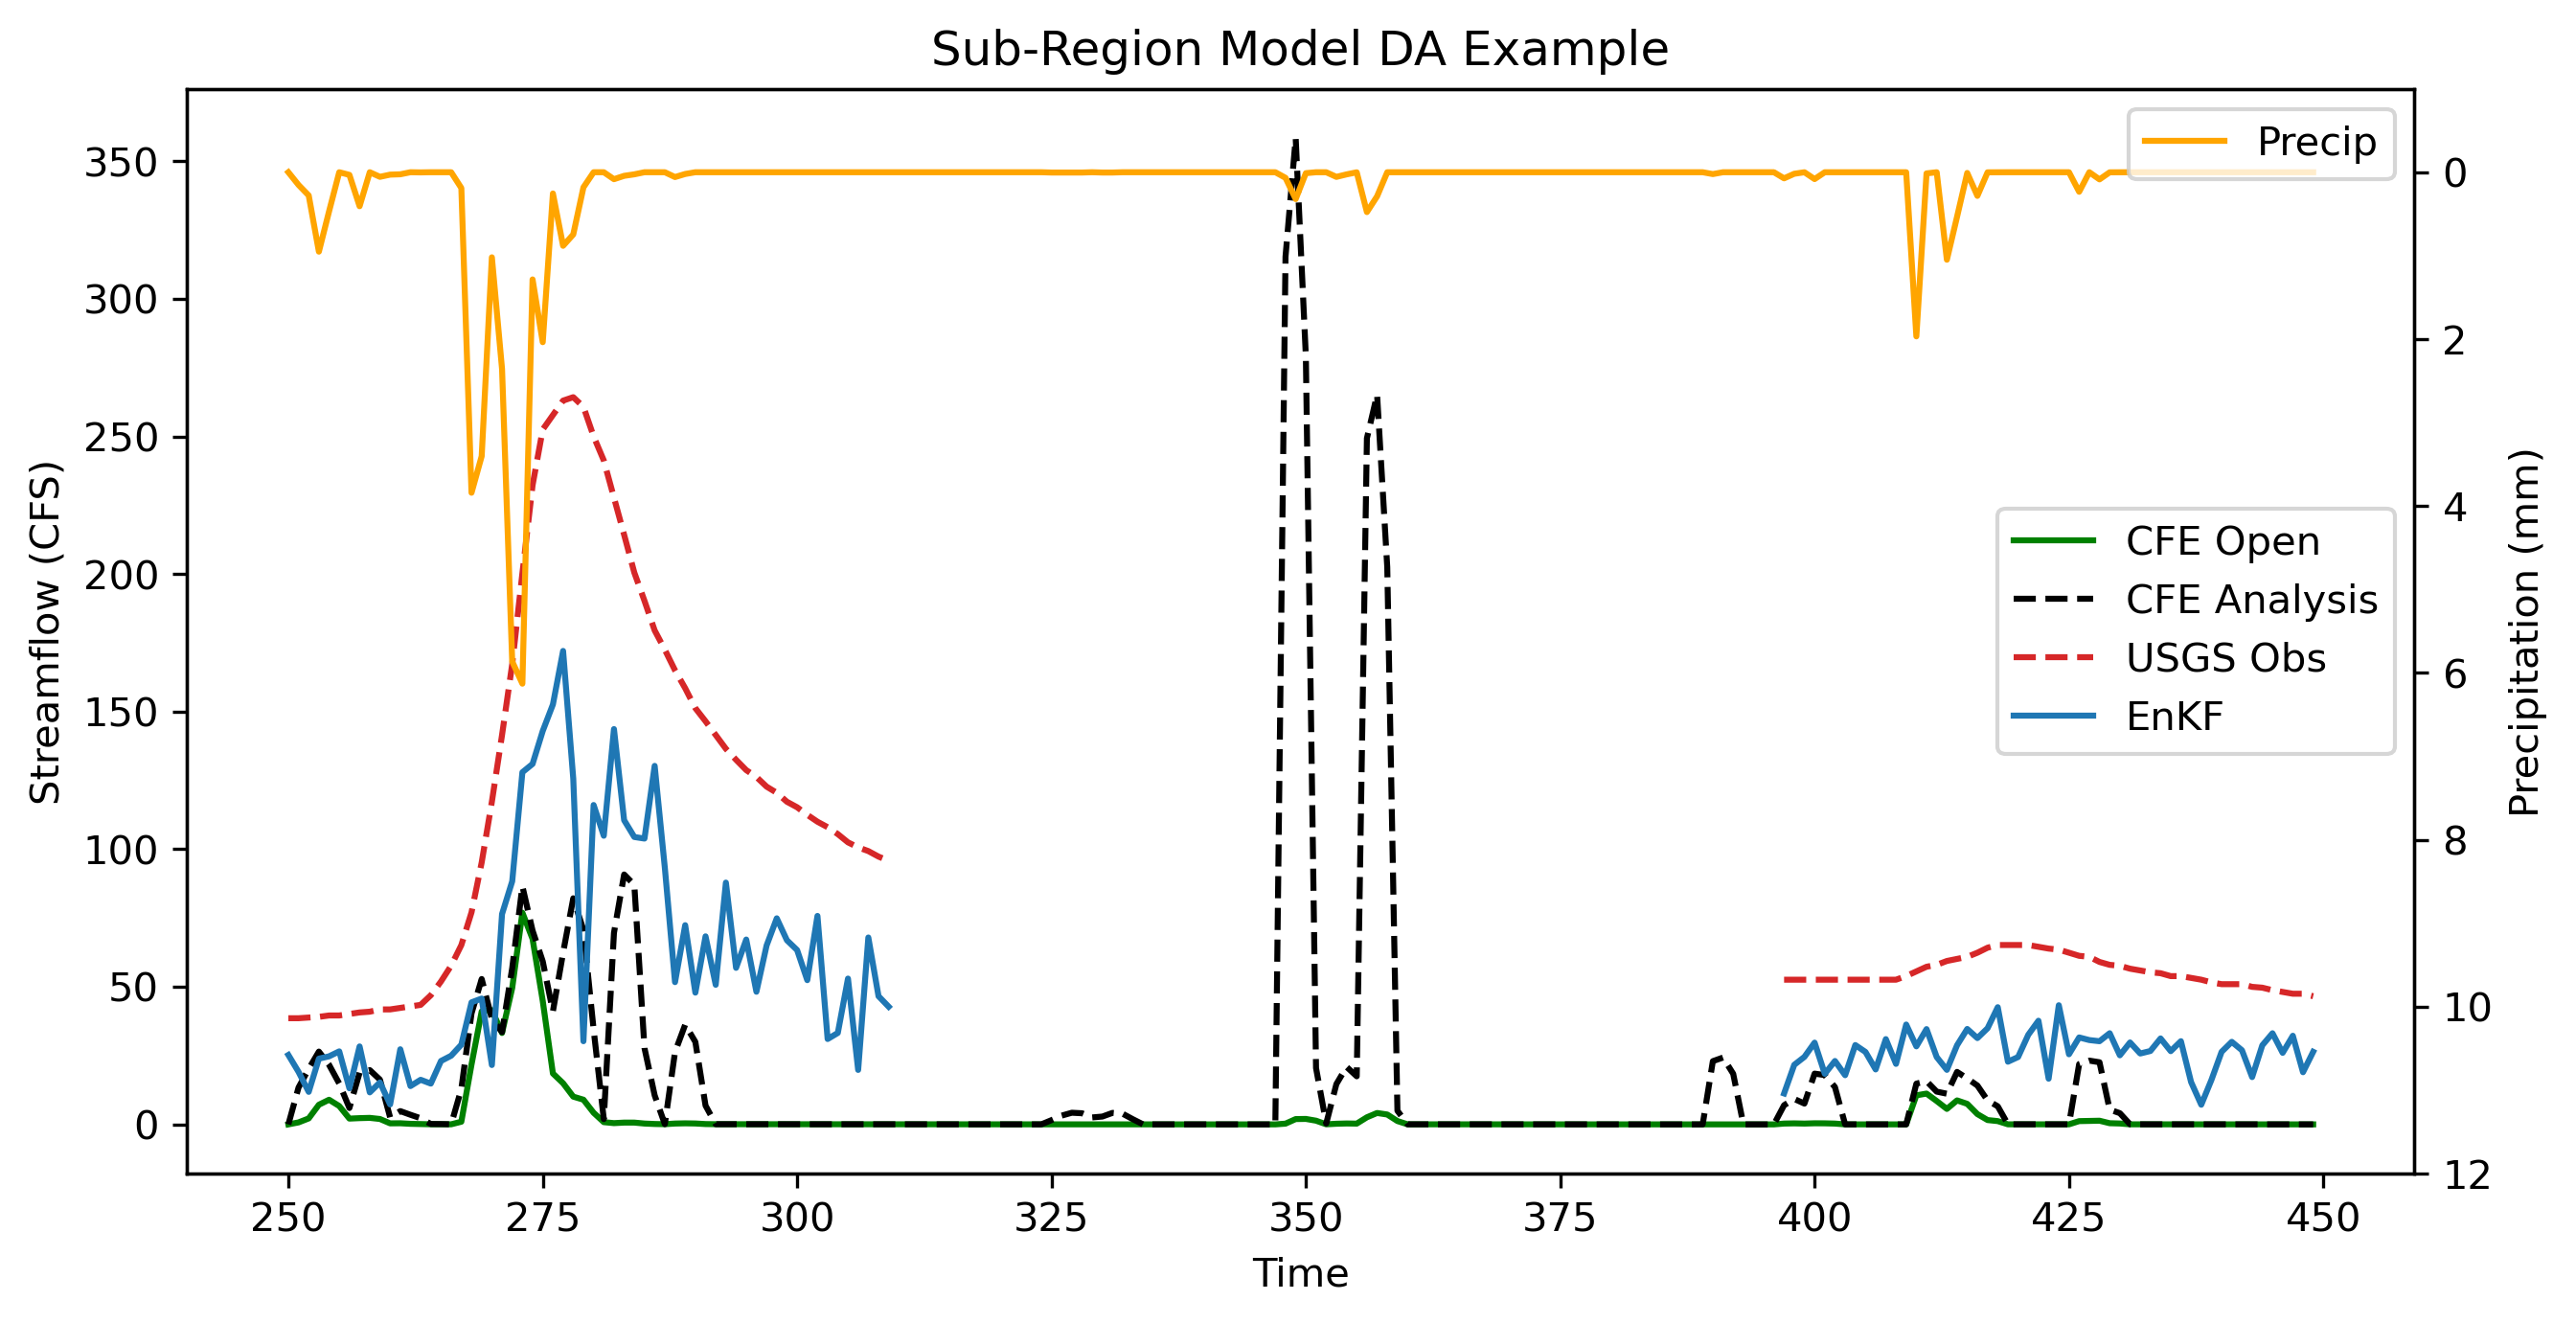

In [12]:
istart_plot=250
iend_plot=450
x = list(range(istart_plot, iend_plot))

fig, ax1 = plt.subplots(figsize = (10,5), dpi=300)

ax2 = ax1.twinx()

ax1.set_xlabel('Time')
ax1.set_ylabel('Streamflow (CFS)')
ax2.set_ylabel('Precipitation (mm)')
ax2.set_ylim(-1,12,1)
ax2.invert_yaxis()


plt.title('Sub-Region Model DA Example')
#plt.plot(x, cfePeturbed[istart_plot:iend_plot], color = 'tab:orange', label = 'CFE Peturbed')
ax1.plot(x, cfeOpen[istart_plot:iend_plot], color = 'green', label = 'CFE Open')
ax1.plot(x, cfeAnalysis[istart_plot:iend_plot], color = 'black', linestyle='dashed', label = 'CFE Analysis')
ax1.plot(x, obs[istart_plot:iend_plot], color = 'tab:red', linestyle='dashed', label = 'USGS Obs')
ax1.plot(x, cfeEnKF[istart_plot:iend_plot], color = 'tab:blue', label = 'EnKF')
ax2.plot(df_forcing['APCP_surface'][istart_plot:iend_plot], color="orange", label = 'Precip')
#plt.ylabel('Streamflow (CFS)')
#plt.xlabel('Time')
ax1.legend(loc='center right')
ax2.legend(loc='upper right')

plt.show()


In [8]:
# cfe_open = bmi_cfe()
# cfe_perturbed = bmi_cfe()
# cfe_analysis = bmi_cfe()
# enkf = bmi_enkf()
# usgs = bmi_usgs()

# cfe_open.initialize(‘config_open.yml’)
# cfe_perturbed.initialize(‘config_perturbed.yml’)
# cfe_analysis.initialize(‘config_analysis.yml’)
# enkf.initialize(‘config_enkf_cfe_basinID.yml’)
# usgs.initialize(‘config_basinID.yml’)

# For time in daterange():
#     forcing = forcings[time]
#     cfe_open.set_value(forcing)
#     cfe_perturbed.set_value(forcing)
#     cfe_analysis.set_value(forcing)
#     usgs.update()
#     obs = usgs.get_value()

#     cfe_open.update()
#     cfe_perturbed.update()
#     mean, variance  = cfe_perturbed.get_value()

#     enkf.set_value(obs, mean, variance )

#     state_transition = enkf.get_value()

#     cfe_analysis.set_value(state_transition)
#     cfe_analysis.update()

#     cfe_perturbed.set_value(state_transition)
#     

#     cfe_updated_everything = cfe_analysis.get_value(everything)
#     cfe_perturbed.set_value(cfe_updated_everything)



# cfe_open.initialize(‘config_open.yml’)
# cfe_perturbed.initialize(‘config_perturbed.yml’)
# cfe_analysis.initialize(‘config_analysis.yml’)
# enkf.initialize(‘config_enkf_cfe_basinID.yml’)
# usgs.initialize(‘config_basinID.yml’)

